In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# libraries 
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pyspark
import pyspark.sql.dataframe
from pyspark.sql.functions import regexp_replace, col, lower
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F

In [4]:
# reading the data as a dataframe 
df = pd.read_csv('/content/drive/MyDrive/28NOV/tripadvisor_european_restaurants.csv', sep=',',low_memory=False)
df.head(5)

restaurant_link       restaurant_name  \
0  g10001637-d10002227                Le 147   
1  g10001637-d14975787      Le Saint Jouvent   
2   g10002858-d4586832       Au Bout du Pont   
3   g10002986-d3510044   Le Relais de Naiade   
4   g10022428-d9767191  Relais Du MontSeigne   

                                   original_location country  \
0  ["Europe", "France", "Nouvelle-Aquitaine", "Ha...  France   
1  ["Europe", "France", "Nouvelle-Aquitaine", "Ha...  France   
2  ["Europe", "France", "Centre-Val de Loire", "B...  France   
3  ["Europe", "France", "Nouvelle-Aquitaine", "Co...  France   
4  ["Europe", "France", "Occitanie", "Aveyron", "...  France   

                region      province                      city  \
0   Nouvelle-Aquitaine  Haute-Vienne             Saint-Jouvent   
1   Nouvelle-Aquitaine  Haute-Vienne             Saint-Jouvent   
2  Centre-Val de Loire         Berry                Rivarennes   
3   Nouvelle-Aquitaine       Correze                   Lacelle   
4            Occitanie       Aveyron  Saint-Laurent-de-Levezou   

                                             address   latitude  longitude  \
0        10 Maison Neuve, 87510 Saint-Jouvent France  45.961674   1.169131   
1   16 Place de l Eglise, 87510 Saint-Jouvent France  45.957040   1.205480   
2           2 rue des Dames, 36800 Rivarennes France  46.635895   1.386133   
3  9 avenue Porte de la Correze 19170, 19170 Lace...  45.642610   1.824460   
4  route du Montseigne, 12620 Saint-Laurent-de-Le...  44.208860   2.960470   

   ... excellent very_good average poor terrible food service value  \
0  ...       2.0       0.0     0.0  0.0      0.0  4.0     4.5   4.0   
1  ...       2.0       2.0     1.0  0.0      0.0  NaN     NaN   NaN   
2  ...       3.0       1.0     0.0  0.0      0.0  NaN     NaN   NaN   
3  ...       1.0       0.0     0.0  0.0      0.0  4.5     4.5   4.5   
4  ...       4.0       7.0     0.0  0.0      0.0  4.5     4.5   4.5   

  atmosphere keywords  
0        NaN      NaN  
1        NaN      NaN  
2        NaN      NaN  
3        NaN      NaN  
4        NaN      NaN  

[5 rows x 42 columns]

In [5]:
# drop unnecessary columns 
df = df.drop(columns=['original_location','restaurant_link','province','region','address','awards','popularity_detailed','popularity_generic','top_tags','special_diets','features','original_open_hours','excellent','very_good','average','poor','terrible','keywords','atmosphere','price_range'])
df.head(5)
             

restaurant_name country                      city   latitude  \
0                Le 147  France             Saint-Jouvent  45.961674   
1      Le Saint Jouvent  France             Saint-Jouvent  45.957040   
2       Au Bout du Pont  France                Rivarennes  46.635895   
3   Le Relais de Naiade  France                   Lacelle  45.642610   
4  Relais Du MontSeigne  France  Saint-Laurent-de-Levezou  44.208860   

   longitude    claimed price_level                  meals          cuisines  \
0   1.169131    Claimed           €          Lunch, Dinner            French   
1   1.205480  Unclaimed           €                    NaN               NaN   
2   1.386133    Claimed           €  Dinner, Lunch, Drinks  French, European   
3   1.824460    Claimed           €          Lunch, Dinner            French   
4   2.960470  Unclaimed      €€-€€€          Lunch, Dinner            French   

  vegetarian_friendly  ... open_days_per_week open_hours_per_week  \
0                   N  ...                NaN                 NaN   
1                   N  ...                NaN                 NaN   
2                   N  ...                NaN                 NaN   
3                   N  ...                NaN                 NaN   
4                   N  ...                NaN                 NaN   

   working_shifts_per_week  avg_rating  total_reviews_count  default_language  \
0                      NaN         4.0                 36.0           English   
1                      NaN         4.0                  5.0     All languages   
2                      NaN         5.0                 13.0           English   
3                      NaN         4.0                 34.0           English   
4                      NaN         4.5                 11.0     All languages   

   reviews_count_in_default_language food  service  value  
0                                2.0  4.0      4.5    4.0  
1                                5.0  NaN      NaN    NaN  
2                                4.0  NaN      NaN    NaN  
3                                1.0  4.5      4.5    4.5  
4                               11.0  4.5      4.5    4.5  

[5 rows x 22 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083397 entries, 0 to 1083396
Data columns (total 22 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   restaurant_name                    1083397 non-null  object 
 1   country                            1083397 non-null  object 
 2   city                               682712 non-null   object 
 3   latitude                           1067607 non-null  float64
 4   longitude                          1067607 non-null  float64
 5   claimed                            1081555 non-null  object 
 6   price_level                        806192 non-null   object 
 7   meals                              635347 non-null   object 
 8   cuisines                           914294 non-null   object 
 9   vegetarian_friendly                1083397 non-null  object 
 10  vegan_options                      1083397 non-null  object 
 11  gluten_free             

In [7]:
# chack missing value 
df.isnull().sum()

restaurant_name                           0
country                                   0
city                                 400685
latitude                              15790
longitude                             15790
claimed                                1842
price_level                          277205
meals                                448050
cuisines                             169103
vegetarian_friendly                       0
vegan_options                             0
gluten_free                               0
open_days_per_week                   489565
open_hours_per_week                  489565
working_shifts_per_week              489565
avg_rating                            96636
total_reviews_count                   52235
default_language                      95193
reviews_count_in_default_language     95193
food                                 484072
service                              479110
value                                480705
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.shape

(185768, 22)

In [10]:
# converting the price values '€', '€€-€€€', and '€€€€' into three categories (low, medium, high)
df['price_level'] = ['low' if x == '€' else 'medium' if x == '€€-€€€' else 'high' if x == '€€€€' else np.nan for x in df['price_level']]
df

restaurant_name  country                city  \
5              L'Auberge Du Vieux Crozet   France           Le Crozet   
6                 Cafe Restaurant NouLou   France         Saint-Denis   
8                          Noste Courtiu   France             Orgibet   
9                          Chez Claudine   France  They-sous-Montfort   
11                             Chez Jiji   France            Rocbaron   
...                                  ...      ...                 ...   
1083288  Bistroteca Baum & Pension Kokel  Romania          Dumbraveni   
1083374                          Althaus  Romania              Harman   
1083375                        Fish4Life  Romania              Harman   
1083381  Restaurant Pizzerie La Turistul  Romania              Rasnov   
1083388                     La Promenada  Romania              Rasnov   

          latitude  longitude    claimed price_level  \
5        46.169823   3.855819    Claimed      medium   
6        44.233078   4.251449    Claimed      medium   
8        42.934000   0.936559    Claimed      medium   
9        48.231495   5.973734    Claimed      medium   
11       43.316850   6.076840  Unclaimed         low   
...            ...        ...        ...         ...   
1083288  46.223766  24.571620    Claimed      medium   
1083374  45.716520  25.686438  Unclaimed      medium   
1083375  45.721745  25.714191    Claimed      medium   
1083381  45.590218  25.465275  Unclaimed      medium   
1083388  45.597910  25.472660    Claimed      medium   

                                              meals  \
5                             Lunch, Dinner, Drinks   
6                                     Lunch, Dinner   
8                             Lunch, Dinner, Drinks   
9        After-hours, Drinks, Lunch, Dinner, Brunch   
11                                    Lunch, Dinner   
...                                             ...   
1083288            Lunch, Dinner, Brunch, Breakfast   
1083374                               Lunch, Dinner   
1083375                               Dinner, Lunch   
1083381                               Lunch, Dinner   
1083388            Breakfast, Lunch, Dinner, Brunch   

                                                  cuisines  \
5                                                   French   
6                                         French, European   
8              French, Cafe, Deli, Contemporary, Gastropub   
9                               French, European, Wine Bar   
11                                       French, Fast food   
...                                                    ...   
1083288      Italian, European, Central European, Romanian   
1083374                                     Pizza, Italian   
1083375       European, Grill, Healthy, Wine Bar, Romanian   
1083381  American, Pizza, European, Grill, Romanian, It...   
1083388                                           Romanian   

        vegetarian_friendly  ... open_days_per_week open_hours_per_week  \
5                         N  ...                7.0                53.5   
6                         N  ...                5.0                30.0   
8                         N  ...                5.0                14.0   
9                         N  ...                6.0                53.0   
11                        N  ...                6.0                33.5   
...                     ...  ...                ...                 ...   
1083288                   Y  ...                7.0               112.0   
1083374                   N  ...                5.0                50.0   
1083375                   N  ...                7.0                84.0   
1083381                   Y  ...                7.0                84.0   
1083388                   Y  ...                7.0                86.5   

         working_shifts_per_week  avg_rating  total_reviews_count  \
5                           12.0         4.5                 64.0   
6                           10

# EDA

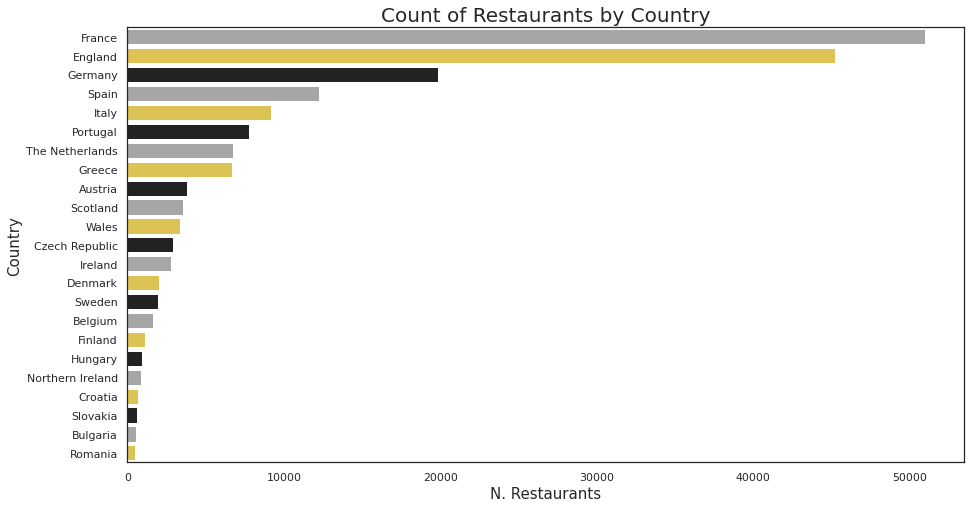

In [11]:
# Count of restaurant countries
sns.set(style='white')

countries_count = df.country.value_counts()

plt.figure(figsize=(15, 8))
plt.title('Count of Restaurants by Country', size=20)
ax = sns.barplot(x=countries_count.values, y=countries_count.index, palette=['#a6a6a6', '#f4d13e','#222222'])
plt.xlabel('N. Restaurants', size=15)
plt.ylabel('Country', size=15)
plt.show()

In [12]:
fig = px.scatter_geo(df, lat='latitude', lon='longitude', color='avg_rating',scope='europe',hover_name='city',
                 projection='natural earth', labels={'avg_rating': 'Rating'},color_continuous_scale=['#a6a6a6', '#f4d13e','#222222'])
fig.show()

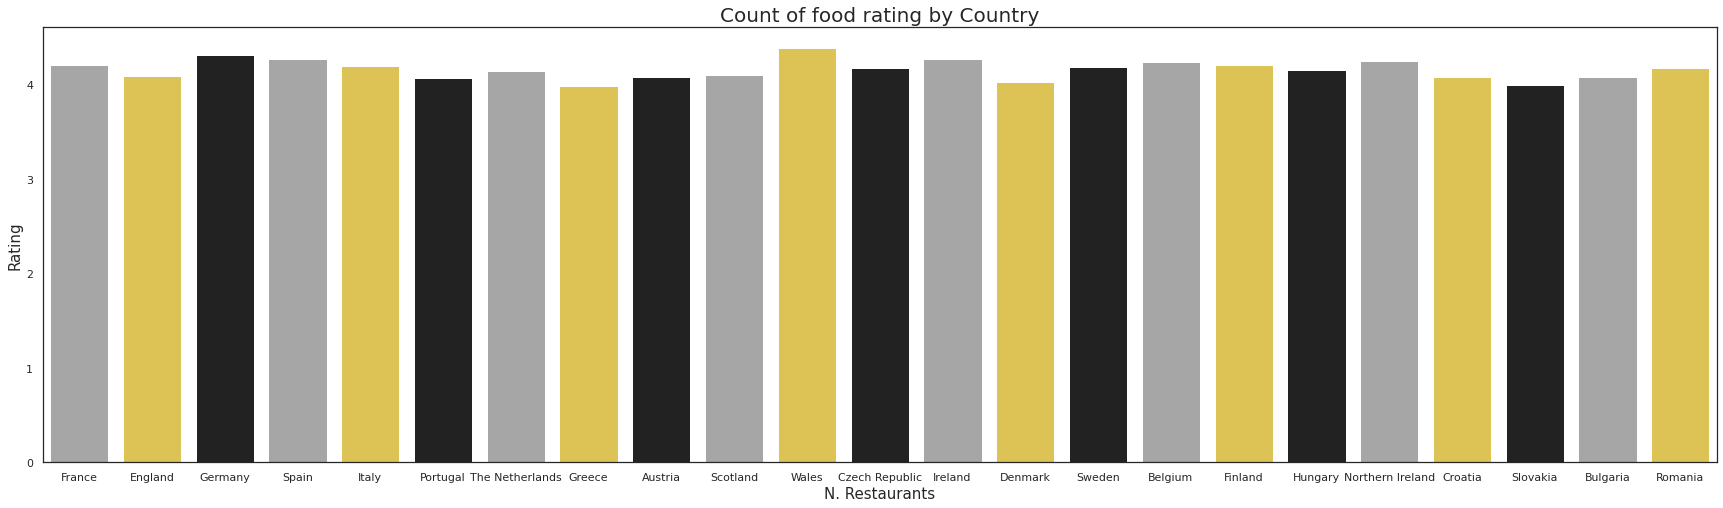

In [13]:
plt.figure(figsize=(30, 8))
plt.title('Count of food rating by Country', size=20)
ax = sns.barplot(x=countries_count.index , y=df.groupby(['country']).mean()['food'], palette=['#a6a6a6', '#f4d13e','#222222'])
plt.xlabel('N. Restaurants', size=15)
plt.ylabel('Rating', size=15)
plt.show()

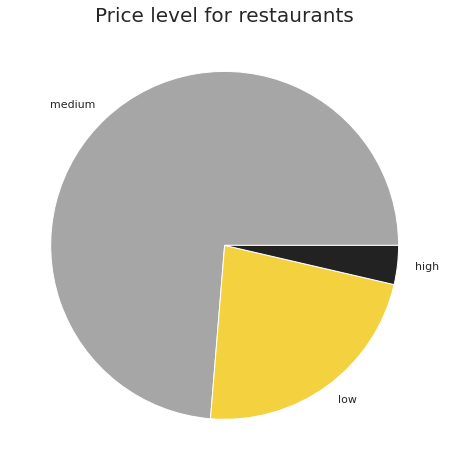

In [14]:
plt.figure(figsize=(30, 8))
plt.title('Price level for restaurants', size=20)
plt.pie(df['price_level'].value_counts().values, labels=df['price_level'].value_counts().index, colors=['#a6a6a6', '#f4d13e','#222222'])
plt.show()

<Figure size 432x288 with 0 Axes>

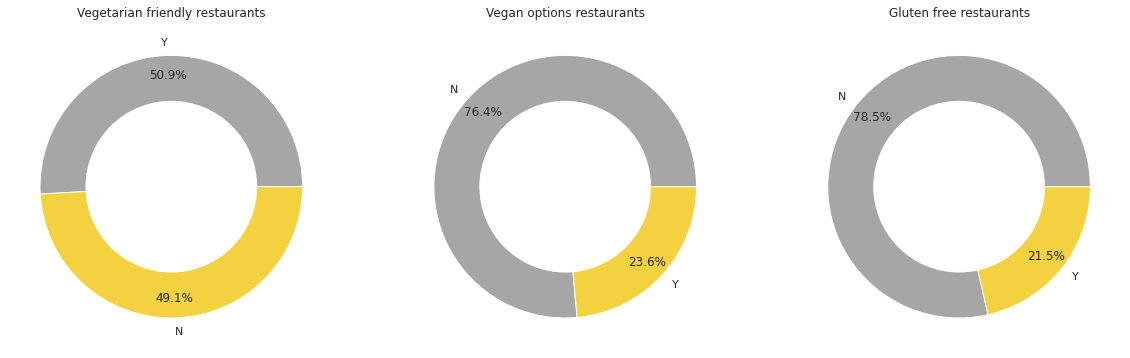

In [15]:
plt.subplots_adjust()
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
plt.title('Vegetarian friendly restaurants')
plt.pie(df['vegetarian_friendly'].value_counts().values, labels=df['vegetarian_friendly'].value_counts().index, autopct='%1.1f%%', pctdistance=0.85,colors=['#a6a6a6', '#f4d13e'])
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.subplot(1, 3, 2)
plt.title('Vegan options restaurants')
plt.pie(df['vegan_options'].value_counts().values, labels=df['vegan_options'].value_counts().index, autopct='%1.1f%%', pctdistance=0.85,colors=['#a6a6a6', '#f4d13e'] )
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.subplot(1, 3, 3)
plt.title('Gluten free restaurants')
plt.pie(df['gluten_free'].value_counts().values, labels=df['gluten_free'].value_counts().index, autopct='%1.1f%%', pctdistance=0.85,colors=['#a6a6a6', '#f4d13e'] )
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.show()

In [16]:
le = LabelEncoder()
le.fit(df['claimed'])
df['claimed'] = le.transform(df['claimed'])
le.fit(df['restaurant_name'])
df['restaurant_name'] = le.transform(df['restaurant_name'])
le.fit(df['country'])
df['country'] = le.transform(df['country'])
le.fit(df['city'])
df['city'] = le.transform(df['city'])
le.fit(df['price_level'])
df['price_level'] = le.transform(df['price_level'])
le.fit(df['meals'])
df['meals'] = le.transform(df['meals'])
le.fit(df['cuisines'])
df['cuisines'] = le.transform(df['cuisines'])
le.fit(df['vegetarian_friendly'])
df['vegetarian_friendly'] = le.transform(df['vegetarian_friendly'])
le.fit(df['vegan_options'])
df['vegan_options'] = le.transform(df['vegan_options'])
le.fit(df['gluten_free'])
df['gluten_free'] = le.transform(df['gluten_free'])
le.fit(df['default_language'])
df['default_language'] = le.transform(df['default_language'])

In [17]:
df.columns

Index(['restaurant_name', 'country', 'city', 'latitude', 'longitude',
       'claimed', 'price_level', 'meals', 'cuisines', 'vegetarian_friendly',
       'vegan_options', 'gluten_free', 'open_days_per_week',
       'open_hours_per_week', 'working_shifts_per_week', 'avg_rating',
       'total_reviews_count', 'default_language',
       'reviews_count_in_default_language', 'food', 'service', 'value'],
      dtype='object')

In [18]:
df.corr()

restaurant_name   country      city  \
restaurant_name                           1.000000 -0.042481  0.011327   
country                                  -0.042481  1.000000 -0.057233   
city                                      0.011327 -0.057233  1.000000   
latitude                                  0.085326 -0.287025 -0.018954   
longitude                                -0.043347 -0.194514  0.046569   
claimed                                  -0.016266 -0.005610  0.005360   
price_level                               0.014904  0.008468  0.000341   
meals                                     0.028960 -0.017597  0.011031   
cuisines                                 -0.047262  0.215166  0.006216   
vegetarian_friendly                       0.110842 -0.000587 -0.009389   
vegan_options                             0.087152  0.000431 -0.012818   
gluten_free                               0.116200  0.028736 -0.013560   
open_days_per_week                        0.035364  0.015277 -0.003397   
open_hours_per_week                       0.005608  0.066057  0.005888   
working_shifts_per_week                  -0.003028 -0.027884  0.013131   
avg_rating                                0.015655 -0.014388 -0.007315   
total_reviews_count                       0.025524  0.023765  0.003099   
default_language                          0.045732  0.007402 -0.006403   
reviews_count_in_default_language         0.091678 -0.052808 -0.012408   
food                                      0.017729 -0.012301 -0.003685   
service                                   0.019832 -0.018996 -0.008246   
value                                     0.025372 -0.032229 -0.009283   

                                   latitude  longitude   claimed  price_level  \
restaurant_name                    0.085326  -0.043347 -0.016266     0.014904   
country                           -0.287025  -0.194514 -0.005610     0.008468   
city                              -0.018954   0.046569  0.005360     0.000341   
latitude                           1.000000   0.016603  0.108365     0.027795   
longitude                          0.016603   1.000000  0.061479     0.019634   
claimed                            0.108365   0.061479  1.000000    -0.061901   
price_level                        0.027795   0.019634 -0.061901     1.000000   
meals                             -0.104768   0.018257 -0.056312     0.078632   
cuisines                          -0.320924   0.073951  0.007485     0.030015   
vegetarian_friendly                0.185653   0.029961  0.010101     0.091824   
vegan_options                      0.085224  -0.036847 -0.138093     0.083214   
gluten_free                        0.113133  -0.136739 -0.194314     0.103417   
open_days_per_week                 0.022318   0.039982  0.050124     0.043846   
open_hours_per_week               -0.111927   0.136629  0.028230     0.031534   
working_shifts_per_week           -0.108258  -0.018548  0.034125     0.020402   
avg_rating                        -0.052823   0.019807 -0.169299    -0.027254   
total_reviews_count               -0.064298  -0.050173 -0.164289     0.060362   
default_language                   0.086264  -0.028259 -0.014485    -0.002984   
reviews_count_in_default_language  0.127208  -0.149143 -0.158092     0.079506   
food                              -0.047184   0.013042 -0.143698    -0.029572   
service                           -0.038960  -0.005378 -0.160714    -0.023974   
value                             -0.035613   0.000970 -0.099603    -0.085760   

                                      meals  cuisines  vegetarian_friendly  \
restaurant_name                    0.028960 -0.047262             0.110842   
country                           -0.017597  0.215166            -0.000587   
city                               0.011031  0.006216            -0.009389   
latitude                          -0.104768 -0.320924             0.185653   
longitude                          0.018257  0.073951             0.029961   


In [19]:
# Connect to the Spark server
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [20]:
# Convert Pandas dataframe to Spark dataframe
schema = StructType([\
    StructField("restaurant_name", IntegerType(), True),\
    StructField("country", IntegerType(), True),\
    StructField("city", IntegerType(), True),\
    StructField("latitude", FloatType(),True),\
    StructField("longitude", FloatType(), True),\
    StructField("claimed", IntegerType(), True),\
    StructField("price_level", IntegerType(), True),\
    StructField("meals", IntegerType(), True),\
    StructField("cuisines", IntegerType(), True),\
    StructField("vegetarian_friendly", IntegerType(), True),\
    StructField("vegan_options", IntegerType(), True),\
    StructField("gluten_free", IntegerType(), True),\
    StructField("open_days_per_week", FloatType(), True),\
    StructField("open_hours_per_week", FloatType(), True),\
    StructField("working_shifts_per_week", FloatType(), True),\
    StructField("avg_rating", FloatType(), True),\
    StructField("total_reviews_count", FloatType(), True),\
    StructField("default_language", IntegerType(), True),\
    StructField("reviews_count_in_default_language", FloatType(), True),\
    StructField("food", FloatType(), True),\
    StructField("service", FloatType(), True),\
    StructField("value", FloatType(), True)])

df_spark = spark.createDataFrame(df, schema=schema)

In [21]:
df_spark.show()

+---------------+-------+-----+---------+---------+-------+-----------+-----+--------+-------------------+-------------+-----------+------------------+-------------------+-----------------------+----------+-------------------+----------------+---------------------------------+----+-------+-----+
|restaurant_name|country| city| latitude|longitude|claimed|price_level|meals|cuisines|vegetarian_friendly|vegan_options|gluten_free|open_days_per_week|open_hours_per_week|working_shifts_per_week|avg_rating|total_reviews_count|default_language|reviews_count_in_default_language|food|service|value|
+---------------+-------+-----+---------+---------+-------+-----------+-----+--------+-------------------+-------------+-----------+------------------+-------------------+-----------------------+----------+-------------------+----------------+---------------------------------+----+-------+-----+
|          60268|      8|11482|46.169823| 3.855819|      0|          2|  585|    9654|                  0|   

In [22]:
df_spark.printSchema()

root
 |-- restaurant_name: integer (nullable = true)
 |-- country: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- claimed: integer (nullable = true)
 |-- price_level: integer (nullable = true)
 |-- meals: integer (nullable = true)
 |-- cuisines: integer (nullable = true)
 |-- vegetarian_friendly: integer (nullable = true)
 |-- vegan_options: integer (nullable = true)
 |-- gluten_free: integer (nullable = true)
 |-- open_days_per_week: float (nullable = true)
 |-- open_hours_per_week: float (nullable = true)
 |-- working_shifts_per_week: float (nullable = true)
 |-- avg_rating: float (nullable = true)
 |-- total_reviews_count: float (nullable = true)
 |-- default_language: integer (nullable = true)
 |-- reviews_count_in_default_language: float (nullable = true)
 |-- food: float (nullable = true)
 |-- service: float (nullable = true)
 |-- value: float (nullable = true)



In [23]:
# Extracting the feature from the data 
df_cols = list(set(df_spark.columns) - {'price_level'})
features = df_spark.select(df_cols)
cols = features.columns
assembler = VectorAssembler(inputCols=cols, outputCol='features')

df_spark = assembler.transform(df_spark)

In [24]:
df_data = df_spark.select(F.col('features'), F.col('price_level').alias('label'))

#Split training and Testing.
df_train, df_test = df_data.randomSplit([0.8, 0.2])

In [25]:
df_train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [26]:
train_rows=df_train.count()
test_rows=df_test.count()

print("Total train :",train_rows)
print("Total test :", test_rows)

Total train : 148491
Total test : 37277


In [27]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [28]:
# Decision Tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_dt = dt.fit(df_train)

In [29]:
# Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
model_rf = rf.fit(df_train)

In [30]:
# LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features")
model_lr= lr.fit(df_train)

In [31]:
# Predictions on the testing set.
pred_dt = model_dt.transform(df_test)
pred_rf = model_rf.transform(df_test)
pred_lr = model_lr.transform(df_test)

In [32]:
# Accuracy Metric
evaluator_A = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# F1 Metric
evaluator_F = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Weighted Precision
evaluator_P = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

# Weighted Recall
evaluator_R = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# Our models
models = [pred_dt, pred_rf, pred_lr]

# Empty lists that will store the scores for each metric for each model.
accuracy = []
F1 = []
precision = []
recall = []

# Simple loop to populate the empty lists with scores of models for each metric.
for model in models:
    accuracy.append(evaluator_A.evaluate(model))
    F1.append(evaluator_F.evaluate(model))
    precision.append(evaluator_P.evaluate(model))
    recall.append(evaluator_R.evaluate(model))

In [33]:
df_ev = pd.DataFrame(list(zip(accuracy, F1, precision, recall)), 
                     columns = ['Accuracy', 'F1 score', 'Weighted Precision', 'Weighted Recall'],
                     index = ['Decision Tree', 'Random Forest', 'Logistic Regression'])

In [34]:
df_ev

Accuracy  F1 score  Weighted Precision  Weighted Recall
Decision Tree        0.761515  0.716678            0.714234         0.761515
Random Forest        0.746385  0.649572            0.754662         0.746385
Logistic Regression  0.756204  0.705014            0.724390         0.756204